#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 10
**CH10A Understanding the gender difference in earnings**

using the cps-earnings dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/cps-earnings/clean/"
data_out = dirname + "da_case_studies/ch10-gender-earnings-understand/"
output = dirname + "da_case_studies/ch10-gender-earnings-understand/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
cps = pd.read_csv(data_in + "morg-2014-emp.csv")


In [5]:
cps = cps.query("uhours>=20 & earnwke>0 & age>=24 & age<=64 & grade92>=44")


In [6]:
# CREATE VARIABLES
cps["female"] = (cps.sex == 2).astype(int)
cps["w"] = cps["earnwke"] / cps["uhours"]
cps["lnw"] = np.log(cps["w"])
## Write out to csv
cps.to_csv(data_out + "earnings_multireg.csv")


In [7]:
#####################
# DISTRIBUTION OF EARNINGS
#######################
cps.loc[:, ["earnwke", "uhours", "w"]].describe()


,earnwke,uhours,w
count,18241.00000,18241.000000,18241.000000
mean,1481.78936,42.970780,34.525791
std,747.92426,9.139368,16.654215
min,0.01000,20.000000,0.000200
25%,923.00000,40.000000,21.634500
50%,1346.00000,40.000000,31.250000
75%,1923.07000,47.000000,45.673000
max,2884.61000,99.000000,144.230500


In [8]:
cps.loc[cps.w >= 1, ["earnwke", "uhours", "w"]].describe()


,earnwke,uhours,w
count,18220.000000,18220.000000,18220.000000
mean,1483.491212,42.970088,34.565432
std,746.672256,9.135281,16.622801
min,38.000000,20.000000,1.025556
25%,923.000000,40.000000,21.634500
50%,1346.000000,40.000000,31.250000
75%,1923.070000,47.000000,45.673000
max,2884.610000,99.000000,144.230500


### Table 10.1 Gender differences in earnings – log earnings and gender

In [9]:
# use robust std
reg = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw~female+age", data=cps).fit(cov_type="HC1")
reg3 = smf.ols(formula="age~female", data=cps).fit(cov_type="HC1")


In [10]:
stargazer = Stargazer([reg, reg2, reg3])
stargazer.custom_columns(["ln wage", "ln wage", "age"], [1, 1, 1])
stargazer.covariate_order(["female", "age", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


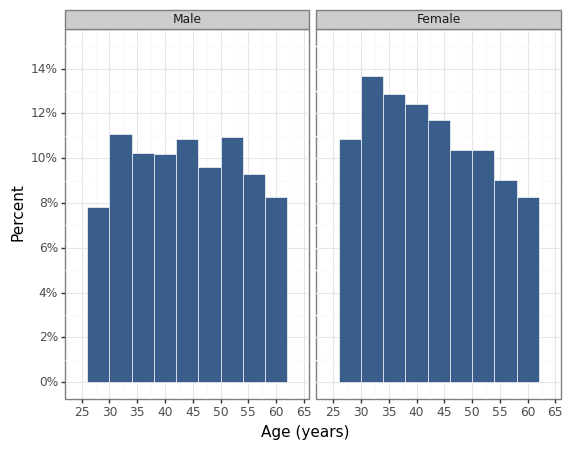

<ggplot: (137309055738)>

In [11]:
(
    ggplot(cps, aes(x="age", y="2*stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="Age (years)", y="Percent")
    + facet_wrap("~female", labeller={"0": "Male", "1": "Female"})
    + labs(x="Age (years)", y="Percent")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)


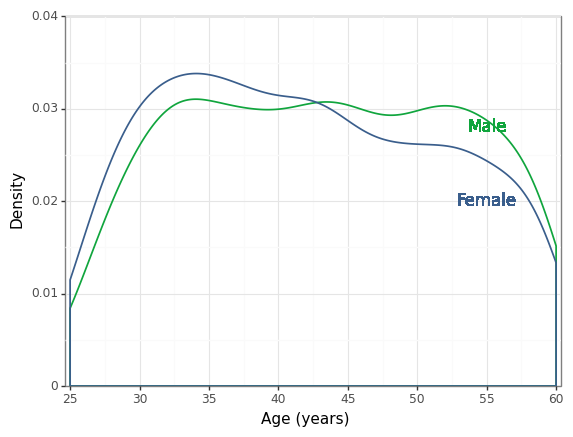

<ggplot: (137313594019)>

In [12]:
(
    ggplot(cps, aes(x="age", y="stat(density)", color="factor(female)"))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="Age (years)", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Male", "Female")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(25, 60), breaks=seq(25, 60, by=5))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.04), breaks=seq(0, 0.04, by=0.01)
    )
    + geom_text(aes(x=55, y=0.028, label="'Male'"), color=color[1], size=12)
    + geom_text(aes(x=55, y=0.020, label="'Female'"), color=color[0], size=12)
    + theme_bw()
)


### Table 10.2 Gender differences in earnings – log earnings and age, various functional forms

In [13]:
cps["agesq"] = np.power(cps["age"], 2)
cps["agecu"] = np.power(cps["age"], 3)
cps["agequ"] = np.power(cps["age"], 4)


In [14]:
reg4 = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1")
reg5 = smf.ols(formula="lnw~female+age", data=cps).fit(cov_type="HC1")
reg6 = smf.ols(formula="lnw~female+age+agesq", data=cps).fit(cov_type="HC1")
reg7 = smf.ols(formula="lnw~female+age+agesq+agecu+agequ", data=cps).fit(cov_type="HC1")


In [15]:
stargazer = Stargazer([reg4, reg5, reg6, reg7])
stargazer.covariate_order(["female", "age", "agesq", "agecu", "agequ", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


### Table 10.3 Gender differences in earnings – log earnings, gender and education

In [16]:
cps["ed_MA"] = (cps["grade92"] == 44).astype(int)
cps["ed_Profess"] = (cps["grade92"] == 45).astype(int)
cps["ed_Phd"] = (cps["grade92"] == 46).astype(int)


In [17]:
reg8 = smf.ols(formula="lnw~female", data=cps).fit(cov_type="HC1")
reg9 = smf.ols(formula="lnw~female + ed_Profess + ed_Phd", data=cps).fit(cov_type="HC1")
reg10 = smf.ols(formula="lnw~female + ed_Profess + ed_MA", data=cps).fit(cov_type="HC1")


In [18]:
stargazer = Stargazer([reg8, reg9, reg10])
stargazer.covariate_order(["female", "ed_Profess", "ed_Phd", "ed_MA", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer


### Table 10.4 Gender differences in earnings – log earnings, gender, age, and their interaction

In [19]:
reg11 = smf.ols(formula="lnw~age", data=cps.query("female==1")).fit(cov_type="HC1")
reg12 = smf.ols(formula="lnw~age", data=cps.query("female==0")).fit(cov_type="HC1")
reg13 = smf.ols(formula="lnw~female+age+age*female", data=cps).fit(cov_type="HC1")


In [20]:
stargazer = Stargazer([reg11, reg12, reg13])
stargazer.covariate_order(["female", "age", "age:female", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant", "age:female": "female x age"})
stargazer.custom_columns(["Women", "Men", "All"], [1, 1, 1])
stargazer


### Figure 10.2 Earning differences by gender as function of age
FOR RPEDICTIONL FUNCTIONAL FORMS & INTERACTIONS WITH GENDER

In [21]:
reg14 = smf.ols(formula="lnw~age+agesq+agecu+agequ", data=cps.query("female==1")).fit(
    cov_type="HC1"
)
reg15 = smf.ols(formula="lnw~age+agesq+agecu+agequ", data=cps.query("female==0")).fit(
    cov_type="HC1"
)
reg16 = smf.ols(
    formula="lnw ~ age + agesq + agecu + agequ + female + female*age + female*agesq + female*agecu + female*agequ",
    data=cps,
).fit(cov_type="HC1")


In [22]:
Stargazer([reg14, reg15, reg16])


In [23]:
# PREDICTION AND GRAPH LINEAR
data_m = cps.query("female==0")

pred = reg13.predict(data_m)

pred = reg13.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]


In [24]:
data_f = cps.query("female==1")

pred = reg13.predict(data_f)

pred = reg13.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]


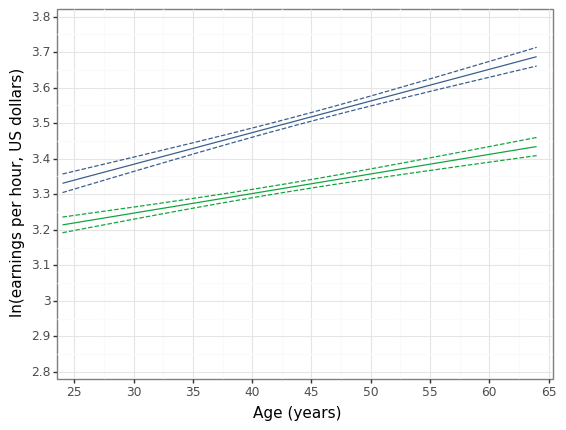

<ggplot: (137308865196)>

In [25]:
(
    ggplot(data_m, aes(x="age", y="fit"))
    + geom_line(colour=color[0])
    + geom_line(data_m, aes(x="age", y="CIup"), colour=color[0], linetype="dashed")
    + geom_line(data_m, aes(x="age", y="CIlo"), colour=color[0], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="fit"), colour=color[1])
    + geom_line(data_f, aes(x="age", y="CIup"), colour=color[1], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="CIlo"), colour=color[1], linetype="dashed")
    + labs(x="Age (years)", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=seq(25, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=seq(2.8, 3.8, by=0.1)
    )
    + theme_bw()
)


In [26]:
# PREDICTION AND GRAPH POLYNOMIAL
# male
data_m = cps.query("female==0")

pred = reg16.predict(data_m)

pred = reg16.get_prediction(data_m).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_m = data_m.reset_index(drop=True).join(pred)

data_m["CIup"] = data_m["fit"] + 2 * data_m["fit_se"]
data_m["CIlo"] = data_m["fit"] - 2 * data_m["fit_se"]

# female
data_f = cps.query("female==1")

pred = reg16.predict(data_f)

pred = reg16.get_prediction(data_f).summary_frame()[["mean", "mean_se"]]
pred.columns = ["fit", "fit_se"]

data_f = data_f.reset_index(drop=True).join(pred)

data_f["CIup"] = data_f["fit"] + 2 * data_f["fit_se"]
data_f["CIlo"] = data_f["fit"] - 2 * data_f["fit_se"]


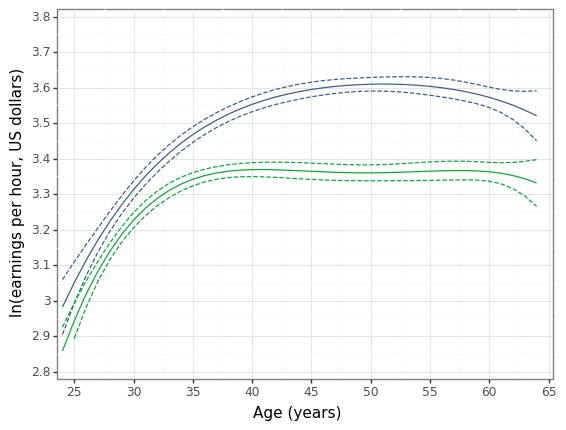

<ggplot: (137341703443)>

In [27]:
(
    ggplot(data_m, aes(x="age", y="fit"))
    + geom_line(colour=color[0])
    + geom_line(data_m, aes(x="age", y="CIup"), colour=color[0], linetype="dashed")
    + geom_line(data_m, aes(x="age", y="CIlo"), colour=color[0], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="fit"), colour=color[1])
    + geom_line(data_f, aes(x="age", y="CIup"), colour=color[1], linetype="dashed")
    + geom_line(data_f, aes(x="age", y="CIlo"), colour=color[1], linetype="dashed")
    + labs(x="Age (years)", y="ln(earnings per hour, US dollars)")
    + scale_x_continuous(expand=(0.01, 0.01), limits=(24, 65), breaks=seq(25, 65, by=5))
    + scale_y_continuous(
        expand=(0.01, 0.01), limits=(2.8, 3.8), breaks=seq(2.8, 3.8, by=0.1)
    )
    + theme_bw()
)


## Part 2
TOWARDS CAUSAL ANALYIS - IS IT DISCRIMINATION?

In [34]:
# FILTER DATA -  SELECTION of the sample we need
cps = cps.query("age>=40 & age<=60")


In [35]:
cps["white"] = (cps["race"] == 1).astype(int)
cps["afram"] = (cps["race"] == 2).astype(int)
cps["asian"] = (cps["race"] == 4).astype(int)
cps["hisp"] = (cps["ethnic"].notna()).astype(int)
cps["othernonw"] = (
    (cps["white"] == 0) & (cps["afram"] == 0) & (cps["asian"] == 0) & (cps["hisp"] == 0)
).astype(int)
cps["nonUSborn"] = (
    (cps["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (cps["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)


In [36]:
# Potentially endogeneous demographics
cps["married"] = ((cps["marital"] == 1) | (cps["marital"] == 2)).astype(int)
cps["divorced"] = ((cps["marital"] == 3) & (cps["marital"] == 5)).astype(int)
cps["wirowed"] = (cps["marital"] == 4).astype(int)
cps["nevermar"] = (cps["marital"] == 7).astype(int)

cps["child0"] = (cps["chldpres"] == 0).astype(int)
cps["child1"] = (cps["chldpres"] == 1).astype(int)
cps["child2"] = (cps["chldpres"] == 2).astype(int)
cps["child3"] = (cps["chldpres"] == 3).astype(int)
cps["child4pl"] = (cps["chldpres"] >= 4).astype(int)

# Work-related variables
cps["fedgov"] = (cps["class"] == "Government - Federal").astype(int)
cps["stagov"] = (cps["class"] == "Government - State").astype(int)
cps["locgov"] = (cps["class"] == "Government - Local").astype(int)
cps["nonprof"] = (cps["class"] == "Private, Nonprofit").astype(int)
cps["ind2dig"] = ((pd.Categorical(cps["ind02"]).codes + 1) / 100).astype(int)
cps["occ2dig"] = (cps["occ2012"] / 100).astype(int)
cps["union"] = ((cps["unionmme"] == "Yes") | (cps["unioncov"] == "Yes")).astype(int)


In [37]:
cps["uhourssq"] = np.power(cps["uhours"], 2)
cps["uhourscu"] = np.power(cps["uhours"], 3)
cps["uhoursqu"] = np.power(cps["uhours"], 4)


### Table 10.5 Gender differences in earnings – regression with many covariates on a narrower sample

In [38]:
# Extended regressions
reg1 = smf.ols(formula="lnw ~ female", data=cps).fit(cov_type="HC1")
reg2 = smf.ols(formula="lnw ~ female + age + ed_Profess + ed_Phd", data=cps).fit(
    cov_type="HC1"
)
reg3 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig)",
    data=cps,
).fit(cov_type="HC1")
reg4 = smf.ols(
    formula="lnw ~ female + age + afram + hisp + asian + othernonw + nonUSborn + ed_Profess + ed_Phd + married + divorced+ wirowed + child1 + child2 + child3 +child4pl + C(stfips) + uhours + fedgov + stagov + locgov + nonprof + union + C(ind2dig) + C(occ2dig) + agesq + agecu + agequ + uhoursqu + uhourscu + uhourssq",
    data=cps,
).fit(cov_type="HC1")


In [39]:
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(["female"])
stargazer.add_line("Age and education", ["", "Yes", "Yes", "Yes"])
stargazer.add_line("Family circumstances", ["", "", "Yes", "Yes"])
stargazer.add_line("Demographic background", ["", "", "Yes", "Yes"])
stargazer.add_line("Job characteristics", ["", "", "Yes", "Yes"])
stargazer.add_line("Age in polynomial", ["", "", "", "Yes"])
stargazer.add_line("Hours in polynomial", ["", "", "", "Yes"])
stargazer
